In [17]:
using Revise

In [2]:
import LinearAlgebra as LA
import SparseArrays as SA
import Plots
using LaTeXStrings
import QuantumOptics as QO

using FFTW:ifft, fft, fftshift, fftfreq

In [99]:
repo_path = "/local/lmseifert/Other/shaken_lattice_qoc/"
src_path = repo_path * "src/"
include(src_path * "system.jl")
include(src_path * "primitives.jl")

to_B_basis (generic function with 1 method)

In [50]:
V = 10. #10.
p_max = 10
system_momentum = ShakenLatticeSystem1D(V, p_max; bloch_basis=false)
mid = system_momentum.params[:mid]
dim = system_momentum.params[:dim]

21

In [149]:
x_max = 100.
n_max = 4
p_max = 2*n_max+1
w = 50
Nx = (2*n_max+1)*w

450

In [59]:
b_momentum = QO.MomentumBasis(-p_max, p_max, Nx)
b_position = QO.PositionBasis(b_momentum)

Position(xmin=-78.53981633974483, xmax=78.53981633974483, N=450)

In [60]:
xs = QO.samplepoints(b_position)
ps = QO.samplepoints(b_momentum)

450-element Vector{Float64}:
 -9.0
 -8.96
 -8.92
 -8.88
 -8.84
 -8.8
 -8.76
 -8.72
 -8.68
 -8.64
 -8.6
 -8.56
 -8.52
  ⋮
  8.52
  8.559999999999999
  8.600000000000001
  8.64
  8.68
  8.719999999999999
  8.760000000000002
  8.8
  8.84
  8.879999999999999
  8.920000000000002
  8.96

In [61]:
Txp = QO.transform(b_position, b_momentum)
Tpx = QO.transform(b_momentum, b_position)

FFTOperators(dim=450x450)
  basis left:  Momentum(pmin=-9, pmax=9, N=450)
  basis right: Position(xmin=-78.53981633974483, xmax=78.53981633974483, N=450)

In [62]:
p_op = QO.momentum(b_momentum)

Operator(dim=450x450)
  basis: Momentum(pmin=-9, pmax=9, N=450)sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  441, 442, 443, 444, 445, 446, 447, 448, 449, 450], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 1

In [63]:
H_kin_p = p_op^2
H_kin_x = QO.LazyProduct(Txp, H_kin_p, Tpx)
H_pot_x = QO.potentialoperator(b_position, x -> -V/2 * cos(2x))
H_pot_p = QO.LazyProduct(Tpx, H_pot_x, Txp)

LazyProduct(dim=450x450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
  operators: 3

In [129]:
#H_x = H_kin_x + H_pot_x
H_p = H_kin_p + H_pot_p

LazySum(dim=450x450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
  operators: 2

function gaussian_wavepacket(x, sigma)
    return (2*sigma^2/pi)^(1/4) * exp.(-sigma^2*x.^2)
end

In [130]:
function gaussian_momentum(p, sigma)
    return (sigma^2*pi)^(-1/4) * exp.(-p.^2/(2*sigma^2))
end

gaussian_momentum (generic function with 1 method)

In [131]:
function momentum_comb(p, v, sigma)
    l = div(length(v),2)
    ns = -l:l
    return gaussian_momentum(p*ones(1,length(ns)) - 2*ones(length(p))*ns', sigma) * v * (1. + 0. * 1im)
end

momentum_comb (generic function with 1 method)

function wave(x, n)
    return exp.(2im*x*n')
end

In [150]:
n0 = 0
ns = -n_max:n_max
v = system_momentum.params[:bloch_states][ns .+ mid .+ n0,4]

9-element Vector{ComplexF64}:
 -0.004574920710789082 - 0.0im
  -0.08734537686975681 - 0.0im
   -0.6873808376493967 - 0.0im
   0.14091636036113409 - 0.0im
  3.02383830537156e-14 + 0.0im
   -0.1409163603613297 - 0.0im
     0.687380837650291 + 0.0im
    0.0873453768698709 - 0.0im
  0.004574920710795054 - 0.0im

v = [1,1,1,1,1,1,1]
l = div(length(v),2)
ns = -l:l

In [170]:
w

50

In [194]:
sigma = 0.2
psi0 = momentum_comb(ps, v, sigma)
psi0_ket = QO.Ket(b_momentum, psi0)

Ket(dim=450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
            -0.0 + 0.0im
            -0.0 + 0.0im
            -0.0 + 0.0im
            -0.0 + 0.0im
        -1.0e-17 + 0.0im
        -1.4e-16 + 0.0im
       -3.12e-15 + 0.0im
      -6.014e-14 + 0.0im
     -9.8903e-13 + 0.0im
   -1.385942e-11 + 0.0im
  -1.6549902e-10 + 0.0im
  -1.68406414e-9 + 0.0im
 -1.460275195e-8 + 0.0im
                 ⋮
  1.460275195e-8 + 0.0im
   1.68406414e-9 + 0.0im
   1.6549902e-10 + 0.0im
    1.385942e-11 + 0.0im
      9.8903e-13 + 0.0im
       6.014e-14 + 0.0im
        3.12e-15 + 0.0im
         1.4e-16 + 0.0im
         1.0e-17 + 0.0im
             0.0 + 0.0im
             0.0 + 0.0im
             0.0 + 0.0im

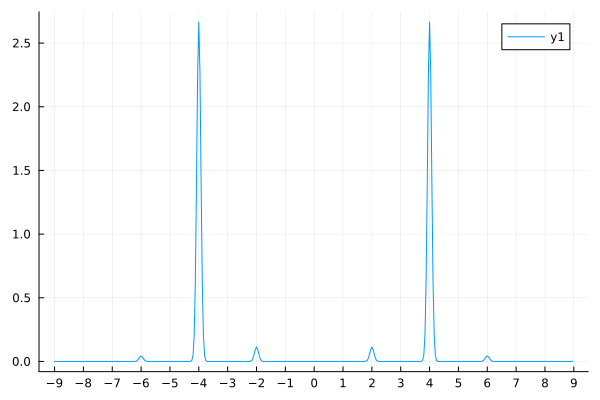

In [195]:
p = Plots.plot(ps, abs2.(psi0))
Plots.xticks!(p, -p_max:p_max)

wave(xs, ns) * v

sigma = 0.1
psi0 = gaussian_wavepacket(xs, sigma) .* (wave(xs, ns) * v)
psi0_ket = QO.Ket(b_position, psi0)

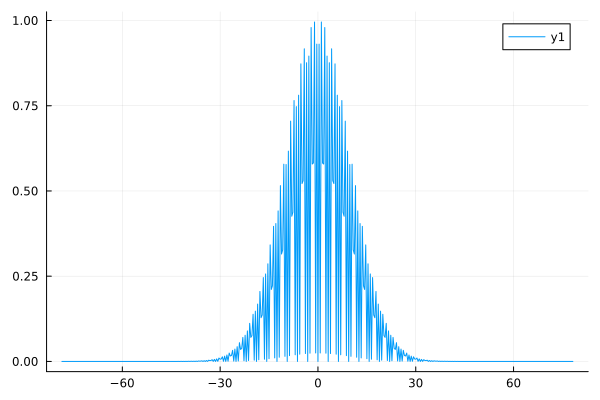

In [196]:
Plots.plot(xs, abs.((Txp*psi0_ket).data))

In [197]:
t_max = 10.0
dt = 0.007
times = collect(0.0:dt:t_max)

1429-element Vector{Float64}:
 0.0
 0.007
 0.014
 0.021
 0.028
 0.035
 0.042
 0.049
 0.056
 0.063
 0.07
 0.077
 0.084
 ⋮
 9.919
 9.926
 9.933
 9.94
 9.947
 9.954
 9.961
 9.968
 9.975
 9.982
 9.989
 9.996

In [198]:
times_mid = div(length(times), 2)

714

In [199]:
#tout, psit_ket = QO.timeevolution.schroedinger(times[1:times_mid], psi0_ket, H_x)
tout, psit_ket = QO.timeevolution.schroedinger(times[1:times_mid], psi0_ket, H_p)

([0.0, 0.007, 0.014, 0.021, 0.028, 0.035, 0.042, 0.049, 0.056, 0.063  …  4.928, 4.935, 4.942, 4.949, 4.956, 4.963, 4.97, 4.977, 4.984, 4.991], QuantumOpticsBase.Ket{QuantumOpticsBase.MomentumBasis{-9, 9, Int64, Int64}, Vector{ComplexF64}}[Ket(dim=450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
            -0.0 + 0.0im
            -0.0 + 0.0im
            -0.0 + 0.0im
            -0.0 + 0.0im
        -1.0e-17 + 0.0im
        -1.4e-16 + 0.0im
       -3.12e-15 + 0.0im
      -6.014e-14 + 0.0im
     -9.8903e-13 + 0.0im
   -1.385942e-11 + 0.0im
  -1.6549902e-10 + 0.0im
  -1.68406414e-9 + 0.0im
 -1.460275195e-8 + 0.0im
                 ⋮
  1.460275195e-8 + 0.0im
   1.68406414e-9 + 0.0im
   1.6549902e-10 + 0.0im
    1.385942e-11 + 0.0im
      9.8903e-13 + 0.0im
       6.014e-14 + 0.0im
        3.12e-15 + 0.0im
         1.4e-16 + 0.0im
         1.0e-17 + 0.0im
             0.0 + 0.0im
             0.0 + 0.0im
             0.0 + 0.0im, Ket(dim=450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
      

In [200]:
psi = zeros(ComplexF64, Nx, length(times))
#psi[:,1:times_mid] = hcat([psi_ket.data for psi_ket in psit_ket]...)
psi[:,1:times_mid] = hcat([(Txp*psi_ket).data for psi_ket in psit_ket]...)
pops = abs2.(psi)

450×1429 Matrix{Float64}:
 2.13983e-28  2.14341e-28  2.15659e-28  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 6.21669e-27  6.22531e-27  6.26529e-27     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.09164e-28  2.16563e-28  2.31064e-28     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.2993e-26   1.31183e-26  1.3242e-26      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.18864e-27  4.14503e-27  4.12619e-27     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.24354e-26  1.26184e-26  1.28702e-26  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 4.36145e-26  4.37288e-26  4.39918e-26     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 5.09677e-28  6.50304e-28  1.04113e-27     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.07691e-25  1.08062e-25  1.08938e-25     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.03487e-28  6.87611e-28  1.97672e-27     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.0067e-25   3.01137e-25  3.0267e-25   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.53907e-29  1.32082e-27  4.65926e-27     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 9.90374e-25  9.92449e-25  9.96423e-25     0.0  0.

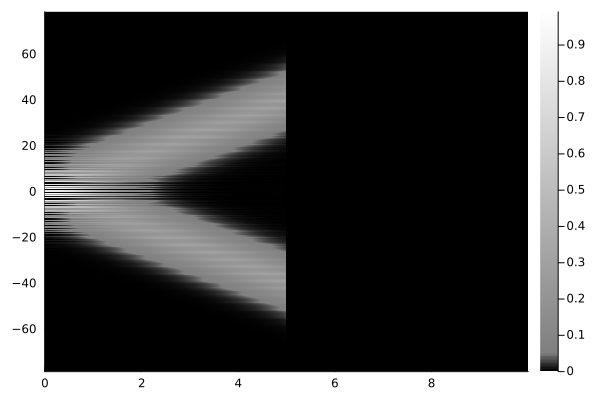

In [201]:
Plots.heatmap(times, xs, pops, c=Plots.cgrad([:black, :white], [0.05]))

In [202]:
psip_final = psit_ket[end]

Ket(dim=450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
        9.0e-17 + 7.0e-17im
        4.6e-16 + 1.4e-16im
       -6.3e-16 - 4.3e-16im
        1.2e-16 + 3.9e-16im
       -1.6e-16 - 2.6e-16im
        4.2e-16 + 6.5e-16im
      -1.19e-15 + 1.63e-15im
     -2.889e-14 - 4.953e-14im
    1.01696e-12 - 3.639e-14im
   -3.64857e-12 + 1.061795e-11im
 -1.2004692e-10 - 7.1601e-11im
  8.8600135e-10 - 8.2695801e-10im
  6.02620951e-9 + 8.51522543e-9im
                ⋮
 -6.02620991e-9 - 8.51522565e-9im
 -8.8600191e-10 + 8.2695798e-10im
  1.2004734e-10 + 7.160107e-11im
    3.64968e-12 - 1.06175e-11im
   -1.01771e-12 + 3.54e-14im
       2.81e-14 + 5.028e-14im
       1.35e-15 - 2.61e-15im
        6.5e-16 + 2.4e-16im
       -4.1e-16 - 5.0e-17im
        2.9e-16 - 2.7e-16im
       -5.3e-16 + 2.9e-16im
        2.6e-16 - 2.4e-16im

psip_final = Tpx * psi_final

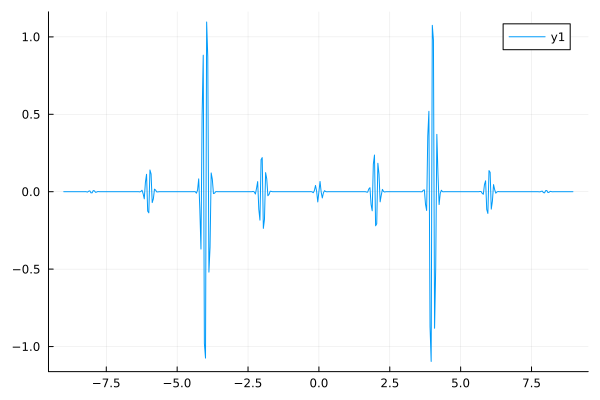

In [203]:
Plots.plot(ps, real.(psip_final.data))

U = collect(LA.I(Nx)) * 1.0im
for i=1:Nx
    U[i,i] = (1+1im)/2
    U[end-i+1, i] = (1-1im)/2
end

import JLD2

data = JLD2.load(repo_path * "notebooks/old/mirror_rollout2.jld2")

U = data["UT"]

Plots.heatmap(abs2.(U))

U = collect(LA.I(Nx)) * 1.0im
for i=1:div(Nx, 2)
    U[i,i] = 0
    U[end-i+1, i] = 1
end
for i=div(Nx, 2)+1:Nx
    U[i,i] = 0
    U[end-i+1, i] = 1
end

v

dp = ps[2] - ps[1]

p_shift = 3 * 2
idx_shift = Int(round(p_shift / dp))

U = collect(LA.I(Nx)) * 1.0im
for i=1:div(Nx, 2)
    U[i,i] = 0
    U[(i + idx_shift - 1) % Nx + 1, i] = 1
end
for i=div(Nx, 2)+1:Nx
    U[i,i] = 0
    U[(i - idx_shift - 1) % Nx + 1, i] = 1
end

In [204]:
I = LA.I(w) * 1.0

50×50 LinearAlgebra.Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅

In [205]:
U = blockmatrix(Nx, Nx, Dict((Nx-i*w+1, (i-1)*w+1) => I for i=1:(2n_max+1)))

450×450 SparseArrays.SparseMatrixCSC{Float64, Int64} with 450 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⎤
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢦⡀⠀⠀⠀⠀⠀⠀⠙⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⣄⠀⠀⠀⠀⠀⠀⠙⠂⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣄⠀⠀⠀⠀⠀⠀⠈⠳⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⢦⡀⠀⠀⠀⠀⠀⠀⠙⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠠⣄⠀⠀⠀⠀⠀⠀⠙⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣄⠀⠀⠀⠀⠀⠀⠈⠳⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

In [206]:
U_op = QO.Operator(b_momentum, U)

Operator(dim=450x450)
  basis: Momentum(pmin=-9, pmax=9, N=450)sparse([401, 402, 403, 404, 405, 406, 407, 408, 409, 410  …  41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

U_x = Txp * U_op * Tpx

In [207]:
psip2 = U_op * psip_final

Ket(dim=450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
       -4.4e-16 - 3.6e-16im
       -5.7e-16 + 1.11e-15im
        2.0e-16 - 7.1e-16im
        4.1e-16 + 1.7e-16im
        8.1e-16 - 4.6e-16im
       -1.9e-15 + 1.2e-16im
       -3.7e-15 + 3.5e-15im
      3.121e-14 + 8.103e-14im
    1.57116e-12 - 2.5022e-13im
      8.537e-13 - 1.807891e-11im
 -2.0291059e-10 - 6.58819e-11im
 -8.7476578e-10 + 1.40806245e-9im
  7.33868003e-9 + 1.256770924e-8im
                ⋮
 -7.33867806e-9 - 1.256770928e-8im
  8.7476538e-10 - 1.40806267e-9im
  2.0291035e-10 + 6.588193e-11im
    -8.5406e-13 + 1.807991e-11im
   -1.57159e-12 + 2.4936e-13im
     -3.007e-14 - 8.206e-14im
       4.15e-15 - 2.03e-15im
        6.0e-16 - 1.7e-16im
      -1.04e-15 - 1.6e-16im
        3.8e-16 + 1.8e-16im
        4.6e-16 + 7.7e-16im
        1.2e-16 - 5.8e-16im

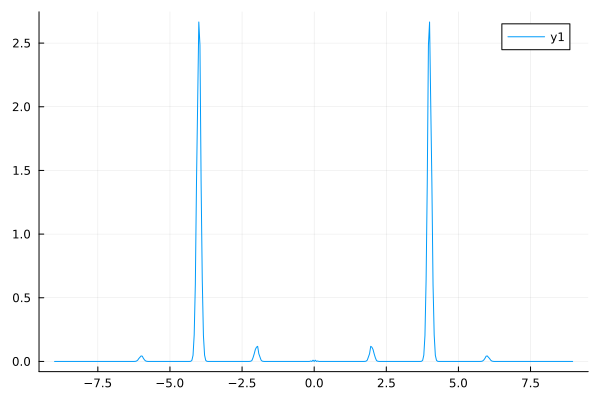

In [208]:
Plots.plot(ps, abs2.(psip_final.data))

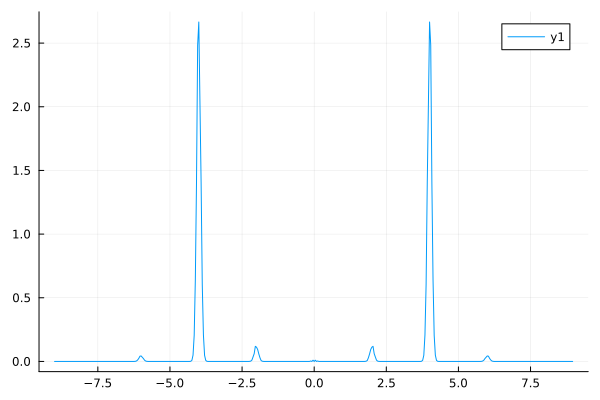

In [209]:
Plots.plot(ps, abs2.(psip2.data))

psi1 = Txp * psip2

psi1 = U_x * psi_final

In [210]:
#tout, psit_ket = QO.timeevolution.schroedinger(times[times_mid+1:end], psi1, H_x)
#tout, psit_ket = QO.timeevolution.schroedinger(times[1:times_mid], psi1, H_x)

tout, psit_ket = QO.timeevolution.schroedinger(times[times_mid+1:end], psip2, H_p)
#tout, psit_ket = QO.timeevolution.schroedinger(times[1:times_mid], psip2, H_p)

([4.998, 5.005, 5.012, 5.019, 5.026, 5.033, 5.04, 5.047, 5.054, 5.061  …  9.933, 9.94, 9.947, 9.954, 9.961, 9.968, 9.975, 9.982, 9.989, 9.996], QuantumOpticsBase.Ket{QuantumOpticsBase.MomentumBasis{-9, 9, Int64, Int64}, Vector{ComplexF64}}[Ket(dim=450)
  basis: Momentum(pmin=-9, pmax=9, N=450)
       -4.4e-16 - 3.6e-16im
       -5.7e-16 + 1.11e-15im
        2.0e-16 - 7.1e-16im
        4.1e-16 + 1.7e-16im
        8.1e-16 - 4.6e-16im
       -1.9e-15 + 1.2e-16im
       -3.7e-15 + 3.5e-15im
      3.121e-14 + 8.103e-14im
    1.57116e-12 - 2.5022e-13im
      8.537e-13 - 1.807891e-11im
 -2.0291059e-10 - 6.58819e-11im
 -8.7476578e-10 + 1.40806245e-9im
  7.33868003e-9 + 1.256770924e-8im
                ⋮
 -7.33867806e-9 - 1.256770928e-8im
  8.7476538e-10 - 1.40806267e-9im
  2.0291035e-10 + 6.588193e-11im
    -8.5406e-13 + 1.807991e-11im
   -1.57159e-12 + 2.4936e-13im
     -3.007e-14 - 8.206e-14im
       4.15e-15 - 2.03e-15im
        6.0e-16 - 1.7e-16im
      -1.04e-15 - 1.6e-16im
        3.8e-1

In [211]:
#psi[:,times_mid+1:end] = hcat([psi_ket.data for psi_ket in psit_ket]...)
psi[:,times_mid+1:end] = hcat([(Txp*psi_ket).data for psi_ket in psit_ket]...)
pops = abs2.(psi)

450×1429 Matrix{Float64}:
 2.13983e-28  2.14341e-28  2.15659e-28  …  1.23484e-27  1.24166e-27
 6.21669e-27  6.22531e-27  6.26529e-27     0.000580836  0.000585158
 2.09164e-28  2.16563e-28  2.31064e-28     1.32594e-6   1.30654e-6
 1.2993e-26   1.31183e-26  1.3242e-26      0.000670237  0.000677041
 4.18864e-27  4.14503e-27  4.12619e-27     0.00022971   0.000230947
 1.24354e-26  1.26184e-26  1.28702e-26  …  0.000258899  0.000260162
 4.36145e-26  4.37288e-26  4.39918e-26     0.000670251  0.000677626
 5.09677e-28  6.50304e-28  1.04113e-27     2.60574e-5   2.62108e-5
 1.07691e-25  1.08062e-25  1.08938e-25     0.00058689   0.000590989
 2.03487e-28  6.87611e-28  1.97672e-27     3.28142e-5   3.25862e-5
 3.0067e-25   3.01137e-25  3.0267e-25   …  0.000576223  0.000580091
 2.53907e-29  1.32082e-27  4.65926e-27     4.81254e-5   4.78934e-5
 9.90374e-25  9.92449e-25  9.96423e-25     0.000671059  0.000676705
 ⋮                                      ⋱               
 9.84113e-25  9.85955e-25  9.89618e-2

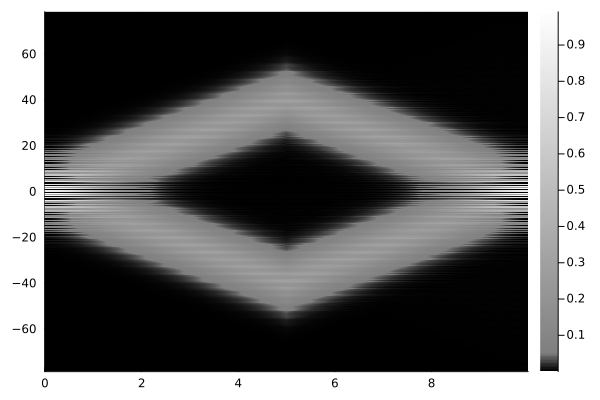

In [212]:
Plots.heatmap(times, xs, pops, c=Plots.cgrad([:black, :white], [0.05]))